# Anime Recommender System

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
sns.set_style('white')
%matplotlib inline

## Get the Data

In [2]:
anime = pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
user = pd.read_csv('rating.csv')
user.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Clean Data 

**Negative 1 is used to indicat|e that a user watched the anime but did not leave a rating. These values were replaced with null. Also, I'm going to only use the first 10,000 users for computational reasons**

In [4]:
user['rating'].replace(-1, np.nan, inplace = True)
user = user[user['user_id'] < 10001]
user.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [5]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

**I'm curious to see the distribution of anime genre. Note that an anime can count towards more than one genre**

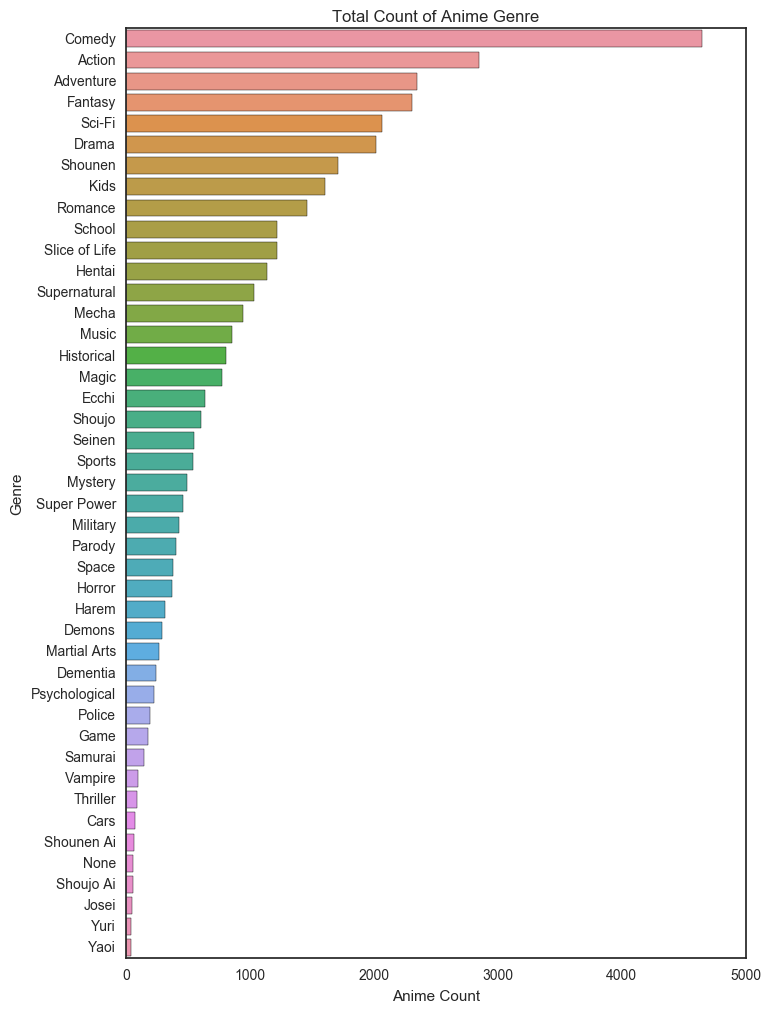

In [6]:
anime['genre'] = anime['genre'].fillna('None') #fill empty null genre
anime['genre'] = anime['genre'].apply(lambda x: x.split(', ')) #split the genre from the column


genre_data = itertools.chain(*anime['genre'].values.tolist())
genre_counter = collections.Counter(genre_data) #count the genre

genres = pd.DataFrame.from_dict(genre_counter, orient = 'index').reset_index().rename(columns={'index':'genre',0:'count'})
genres.sort_values('count', ascending = False, inplace = True)

f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x = 'count', y = 'genre', data = genres)
ax.set(ylabel='Genre',xlabel="Anime Count")
ax.set_title('Total Count of Anime Genre')

**Merged the two datasets together on anime_id column**

In [7]:
merged_anime = pd.merge(anime, user, on = 'anime_id', suffixes = ('_anime','_user'))
merged_anime.head()

,anime_id,name,genre,type,episodes,rating_anime,members,user_id,rating_user
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,NaN


In [8]:
#Top 5 anime with the highest average rating
merged_anime.groupby('name')['rating_user'].mean().sort_values(ascending=False).head()

name
Youshou                                     10.0
Makiba no Shoujo Katri                      10.0
Kamiusagi Rope x Panasonic Collaboration    10.0
Hello Kitty no Circus ga Yatte Kita         10.0
Mazinger ZIP!                               10.0
Name: rating_user, dtype: float64

In [9]:
#Top 5 anime with most ratings
merged_anime.groupby('name')['rating_user'].count().sort_values(ascending=False).head()

name
Death Note                         4727
Shingeki no Kyojin                 3660
Sword Art Online                   3588
Code Geass: Hangyaku no Lelouch    3375
Elfen Lied                         3226
Name: rating_user, dtype: int64

**Create a ratings dataframe with average rating and number of ratings**

In [10]:
#create a dataframe with average anime rating and total number of ratings
ratings = pd.DataFrame(merged_anime.groupby('name')['rating_user'].mean())
ratings['number'] = pd.DataFrame(merged_anime.groupby('name')['rating_user'].count())
ratings.columns = ['Avg Rating', 'Num of Ratings']
ratings.head()

,Avg Rating,Num of Ratings
name,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,7.310680,103
&quot;Bungaku Shoujo&quot; Memoire,7.765432,81
&quot;Bungaku Shoujo&quot; Movie,7.666667,153
.hack//G.U. Returner,7.166667,78
.hack//G.U. Trilogy,7.515152,132


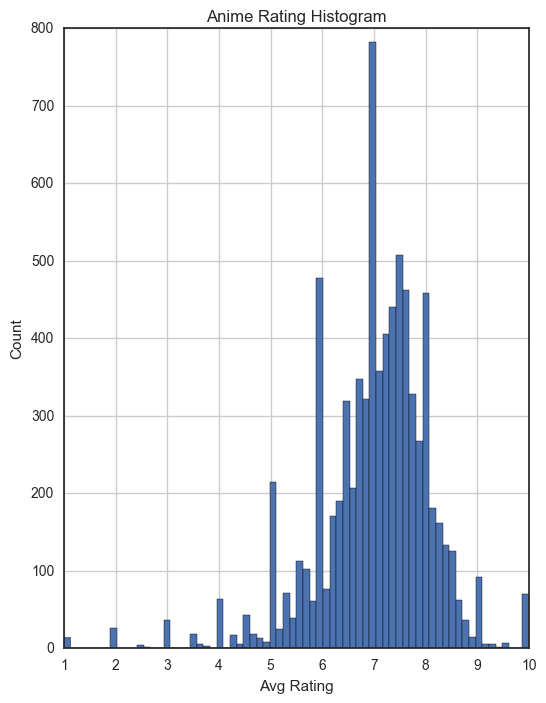

In [11]:
f, ax = plt.subplots(figsize=(6, 8))
ratings['Avg Rating'].hist(bins=70)
ax.set(ylabel='Count',xlabel="Avg Rating")
ax.set_title('Anime Rating Histogram')

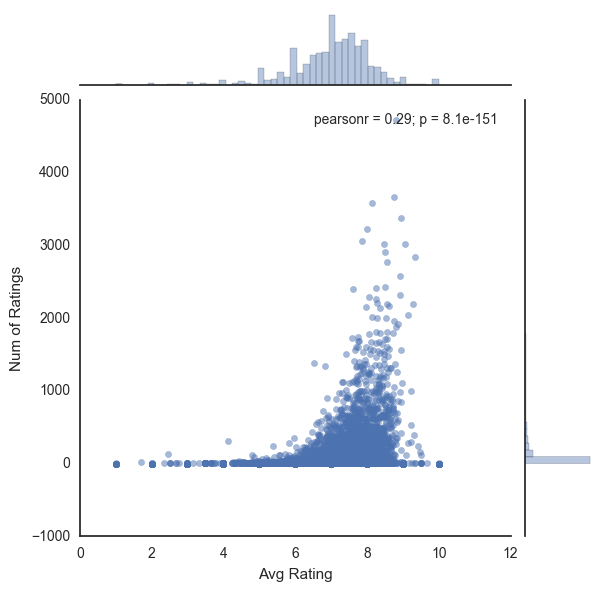

In [12]:
sns.jointplot(x='Avg Rating',y='Num of Ratings',data=ratings,alpha=0.5)

**Let's create a matrix that has the user ids on one axis and the anime title on the other. Each cell will then consist of the ratings the user gave to that anime. Note there will be alot of NaN values as a single user isn't going to see and rank most anime**

In [13]:
matrix = merged_anime.pivot_table(index = ['user_id'], columns = ['name'], values = 'rating_user')
matrix.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [14]:
ratings.sort_values('Num of Ratings', ascending = False).head(10)

,Avg Rating,Num of Ratings
name,,
Death Note,8.818913,4727
Shingeki no Kyojin,8.755191,3660
Sword Art Online,8.142419,3588
Code Geass: Hangyaku no Lelouch,8.935111,3375
Elfen Lied,7.993800,3226
Naruto,7.864794,3062
Code Geass: Hangyaku no Lelouch R2,9.055316,3019
Fullmetal Alchemist,8.468191,3018
Angel Beats!,8.496734,2909


**Now grab user ratings for the movies interested in**

In [15]:
Death_Note_Ratings = matrix['Death Note']
Fullmetal_Alchemist_Ratings = matrix['Fullmetal Alchemist: Brotherhood']
Naruto_Ratings = matrix['Naruto']
One_Punch_Ratings = matrix['One Punch Man']
Shingeki_no_Kyojin_Ratings = matrix['Shingeki no Kyojin']

In [16]:
Similar_to_Death_Note = matrix.corrwith(Death_Note_Ratings)
Similar_to_Fullmetal_Alchemist = matrix.corrwith(Fullmetal_Alchemist_Ratings)
Similar_to_Naruto = matrix.corrwith(Naruto_Ratings)
Similar_to_One_Punch = matrix.corrwith(One_Punch_Ratings)
Similar_to_Attack_on_Titan = matrix.corrwith(Shingeki_no_Kyojin_Ratings)

C:\Users\darie_000\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\darie_000\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


**Death Note Recommendations**

In [17]:
Corr_DeathNote = pd.DataFrame(Similar_to_Death_Note, columns = ['Correlation'])
Corr_DeathNote.dropna(inplace = True) #drops all null values
Corr_DeathNote = Corr_DeathNote.join(ratings['Num of Ratings']) #add total number of ratings to data
Corr_DeathNote[Corr_DeathNote['Num of Ratings']>1000].sort_values('Correlation',ascending=False).head(6) #removes anime with less than 100 ratings

,Correlation,Num of Ratings
name,,
Death Note,1.000000,4727
Code Geass: Hangyaku no Lelouch R2,0.335399,3019
Naruto,0.332193,3062
Code Geass: Hangyaku no Lelouch,0.328404,3375
Shingeki no Kyojin,0.321919,3660
Final Fantasy VII: Advent Children,0.319365,1237


**Fullmetal Alchemist: Brotherhood Recommendations**

In [18]:
Corr_Fullmetal = pd.DataFrame(Similar_to_Fullmetal_Alchemist, columns = ['Correlation'])
Corr_Fullmetal.dropna(inplace = True) 
Corr_Fullmetal = Corr_Fullmetal.join(ratings['Num of Ratings']) 
Corr_Fullmetal[Corr_Fullmetal['Num of Ratings']>1000].sort_values('Correlation',ascending=False).head(6) 

,Correlation,Num of Ratings
name,,
Fullmetal Alchemist: Brotherhood,1.000000,2841
Fullmetal Alchemist: The Conqueror of Shamballa,0.353495,1363
Fullmetal Alchemist,0.347421,3018
Steins;Gate,0.333193,2200
Kami nomi zo Shiru Sekai,0.319481,1246
Soul Eater,0.317196,2265


**Naruto Recommendations**

In [19]:
Corr_Naruto = pd.DataFrame(Similar_to_Naruto, columns = ['Correlation'])
Corr_Naruto.dropna(inplace = True) 
Corr_Naruto = Corr_Naruto.join(ratings['Num of Ratings']) 
Corr_Naruto[Corr_Naruto['Num of Ratings']>1000].sort_values('Correlation',ascending=False).head(6)

,Correlation,Num of Ratings
name,,
Naruto,1.000000,3062
Bleach,0.496932,1464
Dragon Ball Z,0.407463,2007
Fairy Tail,0.406649,1507
Zero no Tsukaima: Princesses no Rondo,0.405597,1131
Dragon Ball GT,0.405076,1340


**One Punch Man Recommendations**

In [20]:
Corr_OnePunch = pd.DataFrame(Similar_to_One_Punch, columns = ['Correlation'])
Corr_OnePunch.dropna(inplace = True) 
Corr_OnePunch = Corr_OnePunch.join(ratings['Num of Ratings']) 
Corr_OnePunch[Corr_OnePunch['Num of Ratings']>1000].sort_values('Correlation',ascending=False).head(6) 

,Correlation,Num of Ratings
name,,
One Punch Man,1.000000,1561
Death Parade,0.368916,1179
Boku dake ga Inai Machi,0.363005,1051
Noragami,0.355454,1815
Tokyo Ghoul,0.355095,2013
Zankyou no Terror,0.354460,1181


**Attack on Titan Recommendations**

In [21]:
Corr_AoT = pd.DataFrame(Similar_to_Attack_on_Titan, columns = ['Correlation'])
Corr_AoT.dropna(inplace = True) 
Corr_AoT = Corr_AoT.join(ratings['Num of Ratings']) 
Corr_AoT[Corr_AoT['Num of Ratings']>1000].sort_values('Correlation',ascending=False).head(6) 

,Correlation,Num of Ratings
name,,
Shingeki no Kyojin,1.000000,3660
Tokyo Ghoul,0.386608,2013
Sword Art Online,0.371680,3588
Kyoukai no Kanata,0.361068,1249
Ao no Exorcist,0.359333,2286
Kuroshitsuji,0.359032,1662
